In [177]:
# importing sys
import sys
 
# adding Folder_2/subfolder to the system path
#sys.path.insert(0, '/notebooks/Desktop/2D_shape_space')
sys.path.append('../utils')
from utils import coefs 

ModuleNotFoundError: No module named 'utils'

In [1]:
from scipy.ndimage import map_coordinates
from imageio import imread
d = "/mnt/c/Users/trang.le/Desktop/2D_shape_space/U2OS_2"
img_id = "757_50_D9_1_3"
protein = imread(f"{d}/{img_id}_protein.png")
shape = imread(f"{d}/{img_id}.png")
avg_shape = imread("/mnt/c/Users/trang.le/Desktop/2D_shape_space/shapespace_plots/Avg_cell.jpg")

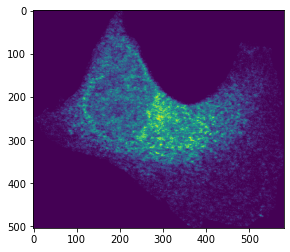

In [3]:
import matplotlib.pyplot as plt
plt.imshow(protein)

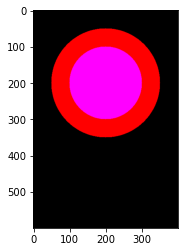

In [4]:
import numpy as np
from skimage.morphology import disk, square, dilation

height, width = 600, 400
#centroid = (, width//2)
target_nu = np.zeros((height, width), dtype=np.uint8)
target_nu[100:301,100:301] = disk(100)
target_cell = np.zeros((height, width), dtype=np.uint8)
target_cell[50:351,50:351] = disk(150)
avg_cell = np.dstack([target_cell, np.zeros((height,width)),target_nu])
plt.imshow(avg_cell)

In [15]:
"""
# In proteins

protein_ch = rotate(imread(pro_path), shift_dict["theta"])

cell__ = []
for fcoef in [ori_fft[: n_coef * 2], ori_fft[n_coef * 2 :]]: 
    ix__, iy__ = inverse_func(fcoef[:n_coef], fcoef[n_coef:])
    cell__ += [np.concatenate([ix__, iy__])]
x_,y_ = parameterize.get_coordinates(cell__[1].real, cell__[0].real, [0,0], n_isos = [10,20], plot=False)

# In average cells
cell__ = []
for fcoef in [ori_fft[: n_coef * 2], ori_fft[n_coef * 2 :]]: 
    ix__, iy__ = inverse_func(fcoef[:n_coef], fcoef[n_coef:])
    cell__ += [np.concatenate([ix__, iy__])]
x_,y_ = parameterize.get_coordinates(cell__[1].real, cell__[0].real, [0,0], n_isos = [10,20], plot=False)

"""


'\n# In proteins\n\nprotein_ch = rotate(imread(pro_path), shift_dict["theta"])\n\ncell__ = []\nfor fcoef in [ori_fft[: n_coef * 2], ori_fft[n_coef * 2 :]]: \n    ix__, iy__ = inverse_func(fcoef[:n_coef], fcoef[n_coef:])\n    cell__ += [np.concatenate([ix__, iy__])]\nx_,y_ = parameterize.get_coordinates(cell__[1].real, cell__[0].real, [0,0], n_isos = [10,20], plot=False)\n\n# In average cells\ncell__ = []\nfor fcoef in [ori_fft[: n_coef * 2], ori_fft[n_coef * 2 :]]: \n    ix__, iy__ = inverse_func(fcoef[:n_coef], fcoef[n_coef:])\n    cell__ += [np.concatenate([ix__, iy__])]\nx_,y_ = parameterize.get_coordinates(cell__[1].real, cell__[0].real, [0,0], n_isos = [10,20], plot=False)\n\n'

In [5]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    print(x.shape)
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

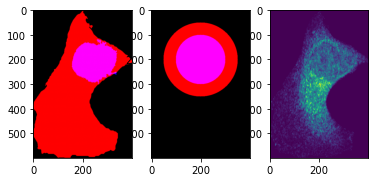

In [9]:
#shape = np.rotate(shape,90)
from skimage.transform import rescale, resize
fig,ax = plt.subplots(1,3)
ax[0].imshow(resize(np.rot90(shape,3), (600,400)))
ax[1].imshow(avg_cell)#elastic_transform(shape,8,0.5))
ax[2].imshow(resize(np.rot90(protein,3), (600,400)))

In [10]:
from skimage.color import rgb2gray
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
# --- Compute the optical flow
results_ = optical_flow_ilk(resize(np.rot90(shape,3), (600,400)), avg_cell, radius=15)

"""
# --- Convert the images to gray level: color is not supported.
image0 = rgb2gray(image0)
image1 = rgb2gray(image1)

# --- Compute the optical flow
v, u = optical_flow_tvl1(image0, image1)

# --- Use the estimated optical flow for registration

nr, nc = image0.shape

"""


'\n# --- Convert the images to gray level: color is not supported.\nimage0 = rgb2gray(image0)\nimage1 = rgb2gray(image1)\n\n# --- Compute the optical flow\nv, u = optical_flow_tvl1(image0, image1)\n\n# --- Use the estimated optical flow for registration\n\nnr, nc = image0.shape\n\n'

In [11]:
image0 = rgb2gray(resize(np.rot90(shape,3), (600,400)))
image1 = rgb2gray(avg_cell)

# --- Compute the optical flow
#from cv2 import calcOpticalFlowPyrLK
#results = calcOpticalFlowPyrLK(image0, image1)
v, u = optical_flow_tvl1(image1, image0) # u=dx/dt, v=dy/dt

600 600 (600, 400) 600 400


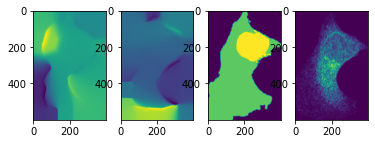

In [12]:
nr, nc = image0.shape

row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')
print(len(row_coords), len(col_coords), image0.shape, nr, nc)

image1_warp = warp(image0, np.array([row_coords + u, col_coords + v]),
                   mode='edge')
fig, ax = plt.subplots(1,4)
ax[0].imshow(u)
ax[1].imshow(v)
ax[2].imshow(image1_warp)
ax[3].imshow(resize(np.rot90(protein,3), (600,400)))

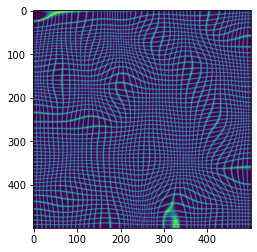

In [104]:
warped = cv.remap(img, xmap, ymap ,cv.INTER_LINEAR)
plt.imshow(warped)

(0.0, 499.0, 0.0, 499.0)

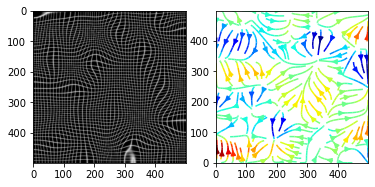

In [64]:
'''
import numpy as np

def bilinear_inverse(p, vertices, numiter=4):
    """
    Compute the inverse of the bilinear map from the unit square
    [(0,0), (1,0), (1,1), (0,1)]
    to the quadrilateral vertices = [p0, p1, p2, p4]

    Parameters:
    ----------
    p: array of shape (2, ...)
        Points on which the inverse transforms are applied.
    vertices: array of shape (4, 2, ...)
        Coordinates of the vertices mapped to the unit square corners
    numiter:
        Number of Newton interations

    Returns:
    --------
    s: array of shape (2, ...)
        Mapped points.

    This is a (more general) python implementation of the matlab implementation 
    suggested in https://stackoverflow.com/a/18332009/1560876
    """

    p = np.asarray(p)
    v = np.asarray(vertices)
    sh = p.shape[1:]
    if v.ndim == 2:
        v = np.expand_dims(v, axis=tuple(range(2, 2 + len(sh))))

    # Start in the center
    s = .5 * np.ones((2,) + sh)
    s0, s1 = s
    for k in range(numiter):
        # Residual
        r = v[0] * (1 - s0) * (1 - s1) + v[1] * s0 * (1 - s1) + v[2] * s0 * s1 + v[3] * (1 - s0) * s1 - p

        # Jacobian
        J11 = -v[0, 0] * (1 - s1) + v[1, 0] * (1 - s1) + v[2, 0] * s1 - v[3, 0] * s1
        J21 = -v[0, 1] * (1 - s1) + v[1, 1] * (1 - s1) + v[2, 1] * s1 - v[3, 1] * s1
        J12 = -v[0, 0] * (1 - s0) - v[1, 0] * s0 + v[2, 0] * s0 + v[3, 0] * (1 - s0)
        J22 = -v[0, 1] * (1 - s0) - v[1, 1] * s0 + v[2, 1] * s0 + v[3, 1] * (1 - s0)

        inv_detJ = 1. / (J11 * J22 - J12 * J21)

        s0 -= inv_detJ * (J22 * r[0] - J12 * r[1])
        s1 -= inv_detJ * (-J21 * r[0] + J11 * r[1])

    return s


def invert_map(xmap, ymap, diagnostics=False):
    """
    Generate the inverse of deformation map defined by (xmap, ymap) using inverse bilinear interpolation.
    """

    # Generate quadrilaterals from mapped grid points.
    quads = np.array([[ymap[:-1, :-1], xmap[:-1, :-1]],
                      [ymap[1:, :-1], xmap[1:, :-1]],
                      [ymap[1:, 1:], xmap[1:, 1:]],
                      [ymap[:-1, 1:], xmap[:-1, 1:]]])

    # Range of indices possibly within each quadrilateral
    x0 = np.floor(quads[:, 1, ...].min(axis=0)).astype(int)
    x1 = np.ceil(quads[:, 1, ...].max(axis=0)).astype(int)
    y0 = np.floor(quads[:, 0, ...].min(axis=0)).astype(int)
    y1 = np.ceil(quads[:, 0, ...].max(axis=0)).astype(int)

    # Quad indices
    i0, j0 = np.indices(x0.shape)

    # Offset of destination map
    x0_offset = x0.min()
    y0_offset = y0.min()

    # Index range in x and y (per quad)
    xN = x1 - x0 + 1
    yN = y1 - y0 + 1

    # Shape of destination array
    sh_dest = (1 + x1.max() - x0_offset, 1 + y1.max() - y0_offset)

    # Coordinates of destination array
    yy_dest, xx_dest = np.indices(sh_dest)

    xmap1 = np.zeros(sh_dest)
    ymap1 = np.zeros(sh_dest)
    TN = np.zeros(sh_dest, dtype=int)

    # Smallish number to avoid missing point lying on edges
    epsilon = .01

    # Loop through indices possibly within quads
    for ix in range(xN.max()):
        for iy in range(yN.max()):
            # Work only with quads whose bounding box contain indices
            valid = (xN > ix) * (yN > iy)

            # Local points to check
            p = np.array([y0[valid] + ix, x0[valid] + iy])

            # Map the position of the point in the quad
            s = bilinear_inverse(p, quads[:, :, valid])

            # s out of unit square means p out of quad
            # Keep some epsilon around to avoid missing edges
            in_quad = np.all((s > -epsilon) * (s < (1 + epsilon)), axis=0)

            # Add found indices
            ii = p[0, in_quad] - y0_offset
            jj = p[1, in_quad] - x0_offset

            ymap1[ii, jj] += i0[valid][in_quad] + s[0][in_quad]
            xmap1[ii, jj] += j0[valid][in_quad] + s[1][in_quad]

            # Increment count
            TN[ii, jj] += 1

    ymap1 /= TN + (TN == 0)
    xmap1 /= TN + (TN == 0)

    if diagnostics:
        diag = {'x_offset': x0_offset,
                'y_offset': y0_offset,
                'mask': TN > 0}
        return xmap1, ymap1, diag
    else:
        return xmap1, ymap1

'''
import cv2 as cv
from scipy import ndimage as ndi

# Simulate deformation field
N = 500
sh = (N, N)
t = np.random.normal(size=sh)
dx = ndi.gaussian_filter(t, 40, order=(0,1))
dy = ndi.gaussian_filter(t, 40, order=(1,0))
dx *= 30/dx.max()
dy *= 30/dy.max()

# Test image
img = np.zeros(sh)
img[::10, :] = 1
img[:, ::10] = 1
img = ndi.gaussian_filter(img, 0.5)

# Apply forward mapping
yy, xx = np.indices(sh)
xmap = (xx-dx).astype(np.float32)
ymap = (yy-dy).astype(np.float32)
warped = cv.remap(img, xmap, ymap ,cv.INTER_LINEAR)
fig, ax = plt.subplots(1,2)
ax[0].imshow(warped, cmap='gray')
color = dy
lw = 1
ax[1].streamplot(xx,yy,dx, dy, color=color, density=1., cmap='jet', arrowsize=1)
ax[1].axis("scaled")

# Displacement field

In [161]:
# Simulate deformation field, going from round (shapemode) to deformed (original shape) image
sh = (600, 400)
nu_centroid
t = np.random.normal(size=sh)
dx = np.zeros(sh)
dy = np.zeros(sh)
#dx[nu_centroid[0],nu_centroid[1]] = avg_nu_centroid[0] - nu_centroid[0]
#dy[nu_centroid[0],nu_centroid[1]] = avg_nu_centroid[1] - nu_centroid[1]
dxy_anchor_points = pts1 - pts2

for dxy, standard_coords in zip(dxy_anchor_points, np.round(pts2)):
    dx[int(standard_coords[0]),int(standard_coords[1])] = dxy[0] 
    dy[int(standard_coords[0]),int(standard_coords[1])] = dxy[1]

In [163]:
dxy_anchor_points

array([[   8.63165531,   48.31400484],
       [  -1.15450067,   64.        ],
       [  -4.32956791,   62.66967177],
       [  -1.42214343,   57.94867057],
       [ -10.0795871 ,   51.93331711],
       [ -22.11470352,   72.86027968],
       [ -19.31771356,   99.12120204],
       [  21.97874683,  118.99295386],
       [  15.97368421,   84.64412896],
       [  26.60170913,   69.46589372],
       [  29.25682006,   49.28313585],
       [  21.76427733,   48.56165861],
       [  31.72743324,   31.88271605],
       [  21.50066811,   29.74314989],
       [  -3.37336967,   37.23931828],
       [ -19.93675384,   47.43468218],
       [  -1.15450067,   64.        ],
       [ 248.639637  ,  -48.        ],
       [ 248.95454545,  -62.72907226],
       [ 245.99027158,  -74.78172383],
       [ 240.40909091,  -87.63731412],
       [ 244.0172578 , -100.67862846],
       [ 233.34164836, -102.63239405],
       [ 216.54249113,  -97.27824617],
       [ 199.44729404,  -99.6086099 ],
       [ 179.55153859,  -

In [168]:
from scipy.interpolate import griddata
# separate displacement field calculation for x and y
grid_dx = griddata(pts2, dxy_anchor_points[0], (grid_x, grid_y), method='nearest')
grid_dy = griddata(pts2, dxy_anchor_points[y], (grid_x, grid_y), method='nearest')

NameError: name 'dxy_anchor' is not defined

In [166]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]
grid_x.shape

(100, 200)

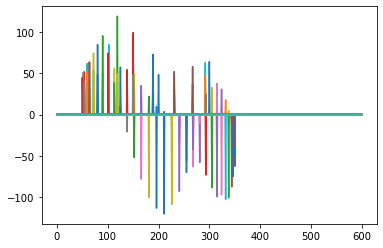

In [167]:
plt.plot(dy)

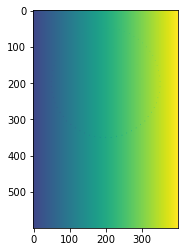

In [165]:
yy, xx = np.indices(sh)
xmap = (xx-dx).astype(np.float32)
ymap = (yy-dy).astype(np.float32)
warped = cv.remap(resize(np.rot90(protein,3),sh), xmap, ymap ,cv.INTER_LINEAR)
plt.imshow(xmap)

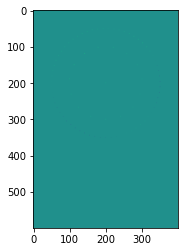

In [164]:
plt.imshow(dy)

# Delaunay triangulation and warpAffine

In [14]:
from scipy.interpolate import interp1d

def equidistance(x, y, n_points=256):
    distance = np.cumsum(
        np.sqrt(np.ediff1d(x, to_begin=0) ** 2 + np.ediff1d(y, to_begin=0) ** 2)
    )

    distance = distance / distance[-1]

    fx = interp1d(distance, x)
    fy = interp1d(distance, y)

    alpha = np.linspace(0, 1, n_points)
    x_regular, y_regular = fx(alpha), fy(alpha)
    return x_regular, y_regular

2389
n_triangles : 164


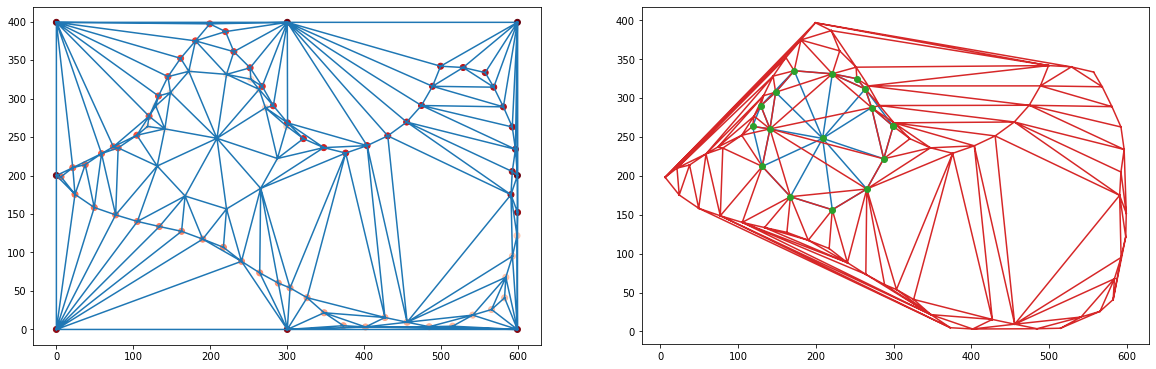

n_triangles : 154
(600, 400, 3) (600, 400, 3)


In [159]:
import cv2
from skimage.measure import find_contours, regionprops
from scipy.ndimage import center_of_mass, rotate
from scipy.spatial import Delaunay

(x_max, y_max,_) = avg_cell.shape
border_anchors = [[0,0],[x_max//2,0],[x_max-1,0],[0,y_max//2],[0,y_max-1],[x_max//2,y_max-1],[x_max-1,y_max//2],[x_max-1,y_max-1]]

ori_shape = resize(np.rot90(shape,3), (600,400))

nu_ = ori_shape[:,:,2]
nu = np.zeros((nu_.shape[0]+2, nu_.shape[1]+2))
nu[1:1+nu_.shape[0],1:1+nu_.shape[1]] = nu_
nu_centroid = center_of_mass(nu) 
nu_contour = find_contours(nu_)
x,y = equidistance(nu_contour[0][:,0], nu_contour[0][:,1], n_points=16)
nu_contour = np.array([[x[i], y[i]] for i in range(len(x))])

cell_ = ori_shape[:,:,0]
cell = np.zeros((cell_.shape[0]+2, cell_.shape[1]+2))
cell[1:1+cell_.shape[0],1:1+cell_.shape[1]] = cell_
cell_contour = find_contours(cell) 
#plt.scatter(cell_contour[0][:,0], cell_contour[0][:,1])
#plt.axis("scaled")
print(len(cell_contour[0]))
x,y = equidistance(cell_contour[0][:,0], cell_contour[0][:,1], n_points=64)
cell_contour = np.array([[x[i], y[i]] for i in range(len(x))])
pts1 = np.vstack([np.array(nu_centroid),nu_contour,cell_contour, border_anchors])


# triangulate all points
dstTri = Delaunay(pts1).simplices
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].triplot(pts1[:,0], pts1[:,1], dstTri)
ax[0].scatter(pts1[:,0], pts1[:,1],c=np.arange(len(pts1)),cmap='Reds')
ax[0].axis("scaled")
print(f"n_triangles : {len(dstTri)}")

# triangulate nucleus and cytoplasm separately
nu_pt = np.vstack([np.array(nu_centroid),nu_contour])
cell_pt = np.vstack([nu_contour,cell_contour])
dstTri = np.vstack([Delaunay(nu_pt).simplices, Delaunay(cell_pt).simplices])
ax[1].triplot(nu_pt[:,0], nu_pt[:,1], Delaunay(nu_pt).simplices)
ax[1].plot(nu_pt[:,0], nu_pt[:,1], 'o')
ax[1].triplot(cell_pt[:,0], cell_pt[:,1], Delaunay(cell_pt).simplices)
ax[1].axis("scaled")
plt.show()
print(f"n_triangles : {len(Delaunay(nu_pt).simplices)+len(Delaunay(cell_pt).simplices)}")


nu_centroid = center_of_mass(avg_cell[:,:,2]) 
nu_contour = find_contours(avg_cell[:,:,2])
x,y = equidistance(nu_contour[0][:,0], nu_contour[0][:,1], n_points=16)
nu_contour = np.array([[x[i], y[i]] for i in range(len(x))])

cell_contour = find_contours(avg_cell[:,:,0]) 
x,y = equidistance(cell_contour[0][:,0], cell_contour[0][:,1], n_points=64)
cell_contour = np.array([[x[i], y[i]] for i in range(len(x))])
pts2 = np.vstack([np.array(nu_centroid),nu_contour,cell_contour, border_anchors])

# Delaunay triangulation
# Each triangle is represented as three integers: each value represents a index in to the original points array.
srcTri = Delaunay(pts1).simplices
dstTri = Delaunay(pts2).simplices
print(avg_cell.shape, ori_shape.shape)
#M = transformation_from_points(tri1, tri2)


#warp_mat = cv2.getAffineTransform(srcTri, dstTri)
#dst = cv2.warpAffine(img, M, (cols, rows))
  

In [152]:
srcTri_set = [set(tri) for tri in srcTri]
dstTri_set = [set(tri) for tri in dstTri]
union = [tri in dstTri_set for tri in srcTri_set]
len(union),sum(union)

(84, 23)

n_triangles : 164


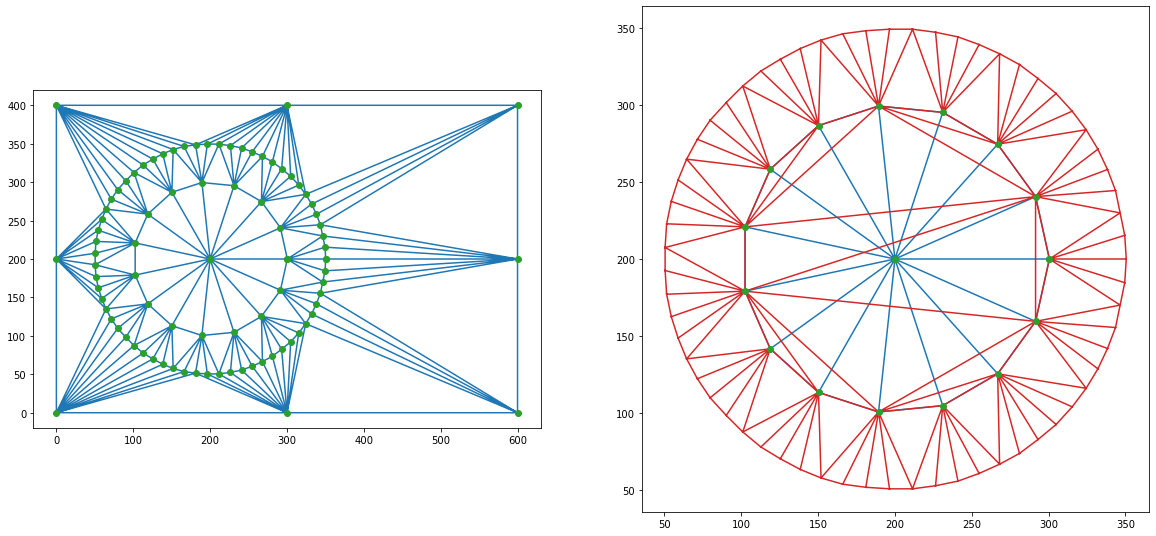

n_triangles : 106


In [18]:
# triangulate all points
dstTri = Delaunay(pts2).simplices
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].triplot(pts2[:,0], pts2[:,1], dstTri)
ax[0].plot(pts2[:,0], pts2[:,1], 'o')
ax[0].axis("scaled")
print(f"n_triangles : {len(dstTri)}")

# triangulate nucleus and cytoplasm separately
nu_pt = np.vstack([np.array(nu_centroid),nu_contour])
cell_pt = np.vstack([nu_contour,cell_contour])
dstTri = np.vstack([Delaunay(nu_pt).simplices, Delaunay(cell_pt).simplices])
ax[1].triplot(nu_pt[:,0], nu_pt[:,1], Delaunay(nu_pt).simplices)
ax[1].plot(nu_pt[:,0], nu_pt[:,1], 'o')
ax[1].triplot(cell_pt[:,0], cell_pt[:,1], Delaunay(cell_pt).simplices)
ax[1].axis("scaled")
plt.show()
print(f"n_triangles : {len(Delaunay(nu_pt).simplices)+len(Delaunay(cell_pt).simplices)}")

n_triangles : 164
n_triangles : 164


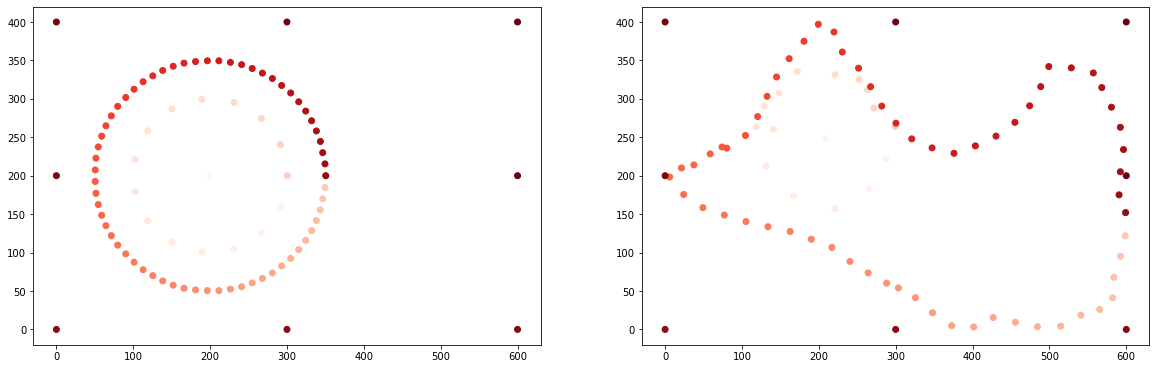

n_triangles : 106


In [19]:
# triangulate all points
c =np.arange(len(dstTri))
dstTri = Delaunay(pts2).simplices
fig, ax = plt.subplots(1,2, figsize=(20,20))
#ax[0].triplot(pts2[:,0], pts2[:,1], dstTri)
#ax[0].tripcolor(pts2[:,0], pts2[:,1], dstTri, facecolors=c)
ax[0].scatter(pts2[:,0], pts2[:,1],c=np.arange(len(pts1)),cmap='Reds')
ax[0].axis("scaled")
print(f"n_triangles : {len(dstTri)}")

# map the triangle on avg cells to raw cell
#ax[1].triplot(pts1[:,0], pts1[:,1], dstTri)
#ax[1].tripcolor(pts1[:,0], pts1[:,1], srcTri, facecolors=c)
ax[1].scatter(pts1[:,0], pts1[:,1],c=np.arange(len(pts1)),cmap='Reds')
ax[1].axis("scaled")
print(f"n_triangles : {len(dstTri)}")

ax[1].axis("scaled")
plt.show()
print(f"n_triangles : {len(Delaunay(nu_pt).simplices)+len(Delaunay(cell_pt).simplices)}")

In [20]:
# we get the Landmark points indexes of each triangle
indexes_triangles = []
for t in triangles:
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])
    index_pt1 = np.where((points == pt1).all(axis=1))
    index_pt1 = extract_index_nparray(index_pt1)
    index_pt2 = np.where((points == pt2).all(axis=1))
    index_pt2 = extract_index_nparray(index_pt2)
    index_pt3 = np.where((points == pt3).all(axis=1))
    index_pt3 = extract_index_nparray(index_pt3)
    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
        triangle = [index_pt1, index_pt2, index_pt3]
        indexes_triangles.append(triangle)

NameError: name 'triangles' is not defined

In [120]:
import numpy as np
import cv2 as cv

def triangle_crop(img, tri):
    mask = np.zeros_like(img, dtype=np.float32)
    cv.fillConvexPoly(mask, np.int32(tri), (1.0, 1.0, 1.0), 16, 0)
    return (mask).astype('uint8') * img

def draw_triangles(img, triangles):
    line = lambda u,v : cv.line(img, (u[0], u[1]), (v[0], v[1]), (255,100,100), 2)
    for u,v,w in triangles:
        line(u,v)
        line(v,w)
        line(w,u)

def draw_point(img, x,y):
    cv.circle(img, (x, y), 2, (0, 255, 0), -1)

def move_coord(vec, x,y):
    vec = vec.copy()
    vec[:,0] -= x
    vec[:,1] -= y
    return vec

def warp_triangles(img, tri_f, tri_to, show_triangles = False, write_canvas = False):
    canvas = np.zeros_like(img)
    print(canvas.shape, tri_f.max(), tri_to.max())
    # warp from u to v
    """
    for u,v in zip(tri_f, tri_to):
        y, x, dy, dx = cv.boundingRect(u)
        crop = img[x:x+dx, y:y+dy]
        u = move_coord(u, y, x)

        yp, xp, dyp, dxp = cv.boundingRect(v)
        v = move_coord(v, yp, xp)

        mat = cv.getAffineTransform(u.astype('float32'), v.astype('float32'))
        warp = cv.warpAffine(crop, mat, (dyp,dxp), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REFLECT_101)
        warp = triangle_crop(warp, v)

        out = canvas[xp:xp+dxp, yp:yp+dyp]
        print(out.shape, warp.shape)
        out += warp * (out == 0)

        if write_canvas:
            cv.imwrite("canvas.jpg", canvas)
"""
    
    if show_triangles:
        draw_triangles(canvas, tri_to)

    return canvas

In [69]:
tri_f = [[pts1[triangle[0]],pts1[triangle[1]],pts1[triangle[2]]] for triangle in dstTri]
tri_f = (np.round(tri_f)).astype('int')#.transpose(0,2,1)
tri_t = [[pts2[triangle[0]],pts2[triangle[1]],pts2[triangle[2]]] for triangle in srcTri]
tri_t = (np.round(tri_t)).astype('int')#.transpose(0,2,1)


In [123]:
#mat = cv.getAffineTransform(np.array([[0, 145, 0], [0, 128, 200]]).T.astype('float32'), np.array([[59, 52, 0], [0, 28, 251]]).T.astype('float32'))
#np.array([[0, 145, 0], [0, 128, 200]]).astype('float32')
tmp = resize(np.rot90(protein,3), (600,400))
line = lambda u,v : cv.line(tmp, (u[0], u[1]), (v[0], v[1]), (255,100,100), 2)
for u,v,w in tri_t:
    line(u,v)
    line(v,w)
    line(w,u)

In [126]:
canvas_out = warp_triangles(resize(np.rot90(protein,3), (600,400)), tri_f, tri_t, show_triangles = False, write_canvas = False)
#plt.imshow(draw_triangles(resize(np.rot90(protein,3), (600,400)), tri_f))

(600, 400) 600 600


In [129]:
ori_shape.shape

(600, 400, 3)

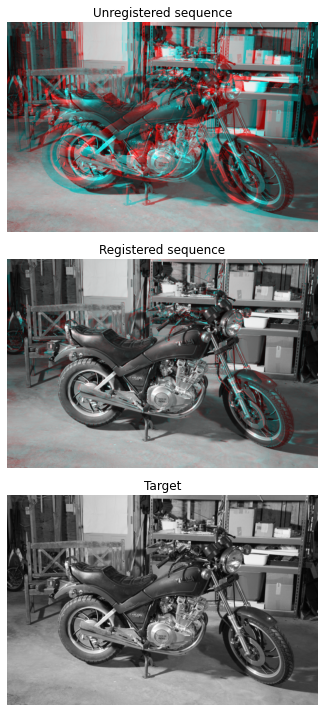

In [168]:
#warp_triangles(protein, tri_f, tr_t, show_triangles = False, write_canvas = False)
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle, vortex
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

# --- Load the sequence
image0, image1, disp = stereo_motorcycle()

# --- Convert the images to gray level: color is not supported.
image0 = rgb2gray(image0)
image1 = rgb2gray(image1)

# --- Compute the optical flow
v, u = optical_flow_tvl1(image0, image1)

# --- Use the estimated optical flow for registration

nr, nc = image0.shape

row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')

image1_warp = warp(image1, np.array([row_coords + v, col_coords + u]),
                   mode='edge')

# build an RGB image with the unregistered sequence
seq_im = np.zeros((nr, nc, 3))
seq_im[..., 0] = image1
seq_im[..., 1] = image0
seq_im[..., 2] = image0

# build an RGB image with the registered sequence
reg_im = np.zeros((nr, nc, 3))
reg_im[..., 0] = image1_warp
reg_im[..., 1] = image0
reg_im[..., 2] = image0

# build an RGB image with the registered sequence
target_im = np.zeros((nr, nc, 3))
target_im[..., 0] = image0
target_im[..., 1] = image0
target_im[..., 2] = image0

# --- Show the result

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(5, 10))

ax0.imshow(seq_im)
ax0.set_title("Unregistered sequence")
ax0.set_axis_off()

ax1.imshow(reg_im)
ax1.set_title("Registered sequence")
ax1.set_axis_off()

ax2.imshow(target_im)
ax2.set_title("Target")
ax2.set_axis_off()

fig.tight_layout()

In [ ]:
import cv2
from skimage.measure import find_contours, regionprops
from scipy.ndimage import center_of_mass, rotate
from scipy.spatial import Delaunay

(x_max, y_max,_) = avg_cell.shape
border_anchors = [[0,0],[x_max//2,0],[x_max,0],[0,y_max//2],[0,y_max],[x_max//2,y_max],[x_max,y_max//2],[x_max,y_max]]

ori_shape = resize(np.rot90(shape,3), (600,400))

nu_ = ori_shape[:,:,2]
nu = np.zeros((nu_.shape[0]+2, nu_.shape[1]+2))
nu[1:1+nu_.shape[0],1:1+nu_.shape[1]] = nu_
nu_centroid = center_of_mass(nu) 
nu_contour = find_contours(nu_)
x,y = equidistance(nu_contour[0][:,0], nu_contour[0][:,1], n_points=16)
nu_contour = np.array([[x[i], y[i]] for i in range(len(x))])

cell_ = ori_shape[:,:,0]
cell = np.zeros((cell_.shape[0]+2, cell_.shape[1]+2))
cell[1:1+cell_.shape[0],1:1+cell_.shape[1]] = cell_
cell_contour = find_contours(cell) 
#plt.scatter(cell_contour[0][:,0], cell_contour[0][:,1])
#plt.axis("scaled")
print(len(cell_contour[0]))
x,y = equidistance(cell_contour[0][:,0], cell_contour[0][:,1], n_points=64)
cell_contour = np.array([[x[i], y[i]] for i in range(len(x))])
pts1 = np.vstack([np.array(nu_centroid),nu_contour,cell_contour, border_anchors])


# triangulate all points
dstTri = Delaunay(pts1).simplices
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].triplot(pts1[:,0], pts1[:,1], dstTri)
ax[0].scatter(pts1[:,0], pts1[:,1],c=np.arange(len(pts1)),cmap='Reds')
ax[0].axis("scaled")
print(f"n_triangles : {len(dstTri)}")

# triangulate nucleus and cytoplasm separately
nu_pt = np.vstack([np.array(nu_centroid),nu_contour])
cell_pt = np.vstack([nu_contour,cell_contour])
dstTri = np.vstack([Delaunay(nu_pt).simplices, Delaunay(cell_pt).simplices])
ax[1].triplot(nu_pt[:,0], nu_pt[:,1], Delaunay(nu_pt).simplices)
ax[1].plot(nu_pt[:,0], nu_pt[:,1], 'o')
ax[1].triplot(cell_pt[:,0], cell_pt[:,1], Delaunay(cell_pt).simplices)
ax[1].axis("scaled")
plt.show()
print(f"n_triangles : {len(Delaunay(nu_pt).simplices)+len(Delaunay(cell_pt).simplices)}")


nu_centroid = center_of_mass(avg_cell[:,:,2]) 
nu_contour = find_contours(avg_cell[:,:,2])
x,y = equidistance(nu_contour[0][:,0], nu_contour[0][:,1], n_points=16)
nu_contour = np.array([[x[i], y[i]] for i in range(len(x))])

cell_contour = find_contours(avg_cell[:,:,0]) 
x,y = equidistance(cell_contour[0][:,0], cell_contour[0][:,1], n_points=64)
cell_contour = np.array([[x[i], y[i]] for i in range(len(x))])
pts2 = np.vstack([np.array(nu_centroid),nu_contour,cell_contour, border_anchors])

# Delaunay triangulation
# Each triangle is represented as three integers: each value represents a index in to the original points array.
srcTri = Delaunay(pts1).simplices
dstTri = Delaunay(pts2).simplices
print(avg_cell.shape, ori_shape.shape)
#M = transformation_from_points(tri1, tri2)


#warp_mat = cv2.getAffineTransform(srcTri, dstTri)
#dst = cv2.warpAffine(img, M, (cols, rows))
  

In [ ]:
dxy =